# Topic Modeling for Finding Table Titles Relevant to Drug-Adverse Events

- The following codes is implemented for topic modeling through LDA in attempt to find document samples(table title data) relevant to drug and adverse events.
- Topic modeling is one of statistical modeling for discovering the abstract 'topics' that occur in a collection of document.
 - An example of topic model is used to classify text in a document to a particular topic
 - it builds a topic per document model and words per topic model, modeled as Dirichlet distributions
- Following urls and research articles were referenced.
 - https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
 - http://www.engear.net/wp/topic-modeling-gensimpython/
 - https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore
 - https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
 - http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
 - http://jeriwieringa.com/2018/07/17/pyLDAviz-and-Mallet/#comment-4018495276
 - https://ldavis.cpsievert.me/reviews/reviews.html
 - https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

### Latent Dirichlet Allocation

#### Data Retrival

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
#retrieve table titles from csv
data = pd.read_csv('titles.csv', delimiter='\t', error_bad_lines=True, header=None)
data.columns = ['id', 'title']
data.title = data.title.str.strip()
documents = data
documents['title'].replace('', np.nan, inplace=True)
documents = documents.astype(str)
print('checking if text is missing')
print(documents.isna().any())
# documents.dropna(subset=['title'], inplace=True)
documents.shape

checking if text is missing
id       False
title    False
dtype: bool


(45352, 2)

#### Data Pre-processing
- tokenization : 
  - split the text into sentences and then sentences into words
  - lower case words
  - remove punctuation
  - remove words with fewer than 2 characters
  - remove all stopwords + added ('table', 'legend')
- Lemmatization : 
 - verbs in past and future tenses are changed into present
- Stemmazation :
 - words are reduced to their root form

In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import strip_numeric
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [5]:
np.random.seed(2018)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/grace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
stemmer = SnowballStemmer('english')
STOP_WORDS = list(gensim.parsing.preprocessing.STOPWORDS)
STOP_WORDS.extend(['table', 'legend'])

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
#     deacc=True removes punctuations
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in STOP_WORDS and len(token)>1:
#             result.append(lemmatize_stemming(strip_numeric(token)))
            result.append(lemmatize_stemming(token))
    return result

In [7]:
%%time
#process the text, save the results as processed_docs
processed_docs = pd.DataFrame()
processed_docs = pd.concat([documents.id, documents.title.map(preprocess)], axis=1)
processed_docs[:5]

CPU times: user 11.4 s, sys: 64 ms, total: 11.5 s
Wall time: 11.5 s


- Trigram model : implement n-grams with Gensim Phrases

In [8]:
#TESTING MIN_COUNT
import itertools

def check_trends_with_min_count(min_count):
    bigram = gensim.models.Phrases(processed_docs.title, min_count=min_count, threshold=1)
    trigram = gensim.models.Phrases(bigram[processed_docs.title], threshold=1)

    #sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    #generated n-grams
    n_grams = []
    word_2d = processed_docs.map(lambda x: trigram_mod[bigram_mod[x]])
    for words in word_2d:
        n_grams.extend(list(filter(lambda x : x.find('_')>=0, words)))
    return set(n_grams)

# n_gram_file = open('n_gram_by_min_count.csv', 'w')
# test_min_counts = list(itertools.chain(range(1, 2), range(50, 500, 50)))
# n_gram_matrix = []
# matrix_index = 0
# for i in reversed(test_min_counts):
#     print('min_count %d' %i)
#     print('matrix_index %d' %matrix_index)
#     if matrix_index > 0:
#         n_gram_matrix.append(list(set(check_trends_with_min_count(i)) - set(n_gram_matrix[matrix_index-1])))
#     else:
#         n_gram_matrix.append(list(set(check_trends_with_min_count(i))))
#     n_gram_file.write(str(i)+'\t'+str(n_gram_matrix[matrix_index])+'\n')
#     matrix_index += 1

# n_gram_file.close()

In [9]:
%%time
#min_count = ignore all words and bigrams with total collected count lower than this value
#threshold = represent a score threshold for forming the phrases(higher means fewer phrases)
bigram = gensim.models.Phrases(processed_docs, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[processed_docs], threshold=1)

#sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.31 ms


In [10]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

In [11]:
def make_bigram(text):
    processed_text = [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in text]
    return [bigram_mod[doc] for doc in processed_text]

def make_trigram(text):
    processed_text = [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in text]
    return trigram_mod[[bigram_mod[doc] for doc in processed_text]]

def explain_make_trigram(text):
    conversion = {}
    for doc in text:
        pro_doc = simple_preprocess(str(doc))
        if doc!= pro_doc:
            print(doc)
            print(pro_doc)
            conversion[doc]=pro_doc
    return conversion

def n_gram_lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text_out = []
    for sent in text:
        doc = nlp(' '.join(sent))
        text_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return text_out

def explain_n_gram_lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    conversions = {}
    for sent in text:
        doc = nlp(' '.join(sent))
        for token in doc:
            if len(token.lemma_) <4 and str(token)!=str(token.lemma_):
                conversions[token] = token.lemma_
#                 print('%s : %s' (token, token.lemma_))
    return conversions

In [12]:
%%time
processed_bigram = n_gram_lemmatization(make_bigram(processed_docs.title))
processed_trigram = n_gram_lemmatization(make_trigram(processed_docs.title))
print(str(len(processed_bigram)))
print(str(len(processed_trigram)))
processed_docs['bigram'] = processed_bigram
processed_docs['trigram'] = processed_trigram
processed_docs.head(10)

45352
45352
CPU times: user 13min 8s, sys: 24min 41s, total: 37min 49s
Wall time: 4min 52s


### bag of words on the data set
- create a dictionary from 'processed_docs' containing the number of times a word appears in the training set

In [13]:
#############
dictionary_made_by = processed_trigram
dictionary_made_by_str = 'trigram'

dictionary = gensim.corpora.Dictionary(dictionary_made_by)
print('size of the dictionary %d' %len(dictionary))
max_dic_size = len(dictionary)
test_dic_sizes = [max_dic_size, int(max_dic_size*2/3), int(max_dic_size/2), 10000]

# count = 0
# for k, v in dictionary.iteritems():
#     if v.find('_')>=0:
#         print(k,v)
#     count += 1
#     if count > 200:
#         break
#     if v.find('tion')>=0:
#         print(k,v)

size of the dictionary 11628


In [14]:
# filter out tokens that appear in less than 0.05 documents 
# or more than 0.5 documents
# after above, keep only the first 40000 most frequent tokens.

#############
dict_size = test_dic_sizes[3]
dictionary.filter_extremes(no_below=0.05, no_above=0.5, keep_n=dict_size)

In [15]:
# vectorize
# Bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in dictionary_made_by]

bow_doc_100 = bow_corpus[100]
for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} times.".format(bow_doc_100[i][0],
                                                     dictionary[bow_doc_100[i][0]],
                                                     bow_doc_100[i][1]))

processed_docs['bow_corpus'] = bow_corpus
processed_docs.head(10)

Word 226 ("clinic") appears 1 times.
Word 236 ("arteri") appears 1 times.
Word 237 ("coronari") appears 1 times.
Word 268 ("calcif") appears 1 times.
Word 269 ("correl") appears 1 times.
Word 270 ("score") appears 1 times.


,id,title,bigram,trigram,bow_corpus
0,4105,"[baselin, characterist]","[baselin, characterist]","[baselin, characterist]","[(0, 1), (1, 1)]"
1,4106,"[analysi, efficaci]","[analysi, efficaci]","[analysi, efficaci]","[(2, 1), (3, 1)]"
2,4107,"[comparison, postop, carbohydr, antigen, level...","[comparison, postop, carbohydr, antigen, level...","[comparison, postop, carbohydr, antigen, level...","[(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1..."
3,4108,"[pattern, diseas, relaps]","[pattern, disea, relap]","[pattern, disea, relap]","[(13, 1), (14, 1), (15, 1)]"
4,4109,"[grade, advers, event, gemcitabin, gemcitabin,...","[grade, adver, event, gemcitabin, gemcitabin, ...","[grade, adver, event, gemcitabin, gemcitabin, ...","[(16, 1), (17, 1), (18, 1), (19, 2), (20, 1)]"
5,4111,"[baselin, characterist]","[baselin, characterist]","[baselin, characterist]","[(0, 1), (1, 1)]"
6,4112,"[treatment, zoledron, acid]","[treatment, zoledron, acid]","[treatment, zoledron, acid]","[(21, 1), (22, 1), (23, 1)]"
7,4113,"[treatment, docetaxel]","[treatment, docetaxel]","[treatment, docetaxel]","[(22, 1), (24, 1)]"
8,4114,"[treatment, relaps, discret, treat, clinician]","[treatment, relap, discret, treat, clinician]","[treatment, relap, discret, treat, clinician]","[(15, 1), (22, 1), (25, 1), (26, 1), (27, 1)]"
9,4115,"[worst, advers, event, grade, report, entir, t...","[bad, adver, event, grade, report, entir, time...","[bad, adver, event, grade, report, entir, time...","[(12, 1), (16, 1), (18, 1), (20, 1), (28, 1), ..."


#### TF-IDF
- tf-idf model on bow_corpus

- tf = count(word, document) / len(document)
- idf = log( len(collection) / count(document_containing_term, collection)
- tf-idf = tf * idf

In [16]:
from gensim import corpora, models
from pprint import pprint

tfidf_mod = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf_mod[bow_corpus]

processed_docs['tfidf_corpus'] = tfidf_corpus
tfidf_doc_100 = tfidf_corpus[100]
for i in range(len(tfidf_doc_100)):
    print("Word {} (\"{}\") appears {} times.".format(tfidf_doc_100[i][0],
                                                     dictionary[tfidf_doc_100[i][0]],
                                                     tfidf_doc_100[i][1]))

Word 226 ("clinic") appears 0.22153788953758755 times.
Word 236 ("arteri") appears 0.33702236441322053 times.
Word 237 ("coronari") appears 0.3058129489306719 times.
Word 268 ("calcif") appears 0.6406461142717561 times.
Word 269 ("correl") appears 0.4491888596048284 times.
Word 270 ("score") appears 0.36279092370991606 times.


In [17]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents bow corpus: %d' % len(bow_corpus))
print('Number of documents tfidf: %d' % len(tfidf_corpus))
print('Number of documents : %d' % len(dictionary_made_by))

Number of unique tokens: 10000
Number of documents bow corpus: 45352
Number of documents tfidf: 45352
Number of documents : 45352


#### Optimal number of topics
- build many LDA models with different values of number of topics and pick the one that gives the highest coherence value based on corpus
- 토픽 모델링 결과로 나온 주제들에 대해 각각의 주제에서 상위 N개의 단어를 뽑습니다. 모델링이 잘 되었을수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 마련입니다. 따라서 상위 단어 간의 유사도를 계산하면 실제로 해당 주제가 의미론적으로 일치하는 단어들끼리 모여있는지 알 수 있습니다.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def compute_coherence_values(model_type, dictionary, corpus, texts, limit, start=2, step=3):
    """
    compute c_v coherence for various number of topics
    
    parameters:
    dictionary : gensim dictionary
    corpus : gensim corpus
    texts : list of input texts
    limit : max number of topics
    
    returns:
    model_list : list of LDA topic models
    coherence_values : coherence value
    """
    
    coherenece_values = []
    u_mass_coherenece_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        if model_type == 'mallet':
            model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, \
                                                     num_topics=num_topics, \
                                                     id2word=dictionary, workers=8, \
                                                     iterations=60)
        elif model_type == 'online':
            model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, \
                                                    num_topics=num_topics, update_every=0, \
                                                    passes=20)
        else:
            model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, \
                                               id2word=dictionary, passes=2, \
                                               workers=8, iterations=60)
        
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        u_mass_coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        
        coherenece_values.append(coherence_model.get_coherence())
        u_mass_coherenece_values.append(u_mass_coherence_model.get_coherence())

    return model_list, coherenece_values, u_mass_coherenece_values

def find_optimal_topic_num(model_type, model_list, coherence_values, umass_co_val):   
    #graph
    print('======== '+model_type + ' ========')
    fig = plt.figure(figsize=(10,5))

    x = range(start, limit, step)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(x, coherence_values)
    ax1.set_xlabel("Number of Topics")
    ax1.set_ylabel("Coherence score")
    #     plt.legend(("coherence_values"), loc="best")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(x, umass_co_val)
    ax2.set_xlabel("Number of Topics")
    ax2.set_ylabel("u mass Coherence score")
    #     plt.legend(("u mass coherence_values"), loc="best")

    fig.savefig(directory+'/'+model_type+'_coherence.png')

    # Print the coherence scores
    # one that maximizes the topic coherence
    print('Coherence c_v ================')
    max_coherence_topic_num = 8 #default
    prev_co = 0
    first_max_cohe_found = False
    for m, cv in zip(x, coherence_values):
        cur_coherence = round(cv, 4)
        print("Num Topics =", m, " has Coherence cv Value of", cur_coherence)
#         if (cur_coherence > 0.32) and m > 5:
        if m > 5:
            if (prev_co <= cur_coherence) and not first_max_cohe_found:
                max_coherence_topic_num = m
            else:
                first_max_cohe_found = True
        prev_co = cur_coherence
    print('Best number of topic is : %d' %max_coherence_topic_num)

    print('Coherence umass ================')
    #where score plateaus안정
    for m, um in zip(x, umass_co_val):
        print("Num Topics =", m, " has Coherence umass Value of", round(um, 4))
    
    return max_coherence_topic_num

In [19]:
model_config='dic_'+dictionary_made_by_str+'_size_'+str(len(dictionary))

import os
directory ='./stat_files/'+model_config
if not os.path.exists(directory):
    os.makedirs(directory)

======== online ========
Coherence c_v ================
Num Topics = 2  has Coherence cv Value of 0.238
Num Topics = 3  has Coherence cv Value of 0.3631
Num Topics = 4  has Coherence cv Value of 0.3696
Num Topics = 5  has Coherence cv Value of 0.3613
Num Topics = 6  has Coherence cv Value of 0.3875
Num Topics = 7  has Coherence cv Value of 0.4211
Num Topics = 8  has Coherence cv Value of 0.4746
Num Topics = 9  has Coherence cv Value of 0.4279
Num Topics = 10  has Coherence cv Value of 0.3961
Num Topics = 11  has Coherence cv Value of 0.4683
Num Topics = 12  has Coherence cv Value of 0.4629
Num Topics = 13  has Coherence cv Value of 0.4612
Num Topics = 14  has Coherence cv Value of 0.4535
Num Topics = 15  has Coherence cv Value of 0.4565
Num Topics = 16  has Coherence cv Value of 0.455
Num Topics = 17  has Coherence cv Value of 0.4441
Num Topics = 18  has Coherence cv Value of 0.449
Num Topics = 19  has Coherence cv Value of 0.5071
Num Topics = 20  has Coherence cv Value of 0.4363
Num T

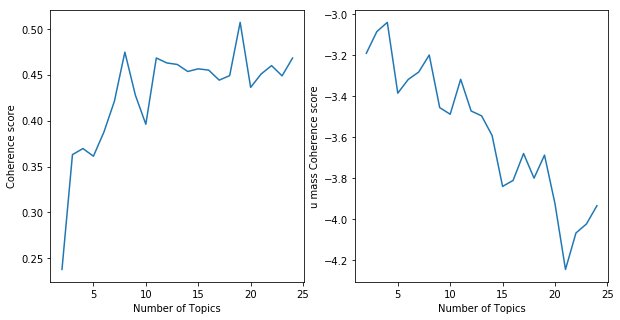

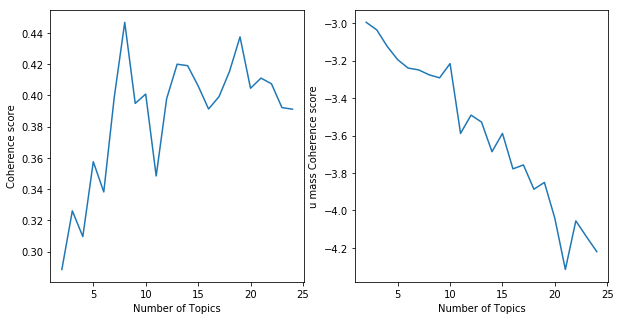

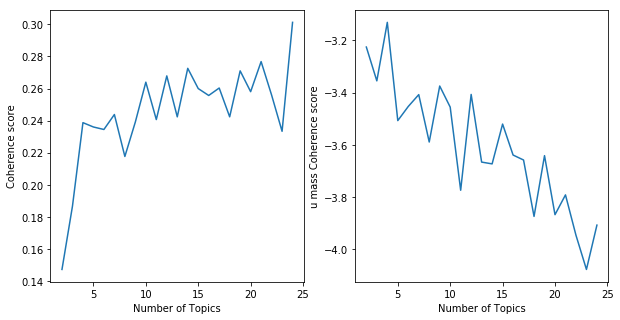

In [20]:
%%time
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet'
from gensim.models import CoherenceModel
limit = 25; start=2; step=1;

model_list_on, coherence_values_on, umass_co_val_on = compute_coherence_values(model_type='online', dictionary=dictionary, \
                                                                      corpus=bow_corpus, \
                                                                      texts=processed_trigram, \
                                                                      start=start, \
                                                                      limit=limit, \
                                                                      step=step)
max_coherence_topic_num_on= find_optimal_topic_num('online', model_list_on, coherence_values_on, umass_co_val_on)

model_list, coherence_values, umass_co_val = compute_coherence_values(model_type='mallet', dictionary=dictionary, \
                                                                      corpus=bow_corpus, \
                                                                      texts=processed_trigram, \
                                                                      start=start, \
                                                                      limit=limit, \
                                                                      step=step)
max_coherence_topic_num = find_optimal_topic_num('mallet', model_list, coherence_values, umass_co_val)

model_list_tfidf, coherence_values_tfidf, umass_co_val_tfidf = compute_coherence_values(model_type='tfidf', dictionary=dictionary, \
                                                                                              corpus=tfidf_corpus, \
                                                                                              texts=processed_trigram, \
                                                                                              start=start, \
                                                                                              limit=limit, \
                                                                                              step=step)
max_coherence_topic_num_tfidf = find_optimal_topic_num('tfidf', model_list_tfidf, coherence_values_tfidf, umass_co_val_tfidf)

### LDA using bag of words

- train LDA using gensim.models.LdaMulticore

In [21]:
# lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=8, id2word=dictionary, passes=2, workers=2)
# for idx, topic in lda_model_bow.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

#is mallet better?
from pathlib import Path
import math

dir_to_check = Path(directory+'/data/')
if not dir_to_check.is_dir():
    os.makedirs(directory+'/data/')

def get_optimal_model(model_type, optimal_topic_num):
#     optimal_topic_num = max_coherence_topic_num
    if model_type=='mallet':
        model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, \
                                                      corpus=bow_corpus, \
                                                      num_topics=optimal_topic_num, \
                                                      id2word=dictionary,\
                                                      iterations=100,\
                                                      prefix=directory+'/data/')
    elif model_type=='online':
        model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, id2word=dictionary, \
                                                    num_topics=optimal_topic_num, update_every=0, \
                                                    passes=20)
    else:
        model = gensim.models.LdaMulticore(tfidf_corpus,\
                                             num_topics=max_coherence_topic_num_tfidf, \
                                             id2word=dictionary, \
                                             passes=2, \
                                             workers=8,\
                                            iterations=100)
        
    #show topics
    pprint(model.show_topics(formatted=False))
    # lda_mallet.save('./data/mallet_topics_num_'+str(optimal_topic_num)+'_'+model_config+'.state.gz')
#     model.load_word_topics()
  
    fig = plt.figure(figsize=(15,20))
    fig.suptitle(model_type+'_topics_num_'+str(optimal_topic_num)+'_'+model_config)

    for i in range(optimal_topic_num):
        df=pd.DataFrame(model.show_topic(i), columns=['term','prob']).set_index('term')

        axi = fig.add_subplot(math.ceil(optimal_topic_num/2),2,i+1)
        axi.set_title('topic '+str(i+1))
        sns.barplot(x='prob', y=df.index, data=df, palette='Reds_d')
        axi.set_xlabel('probability')

    # plt.show()
    fig.savefig(directory+'/'+model_type+'_topics_num_'+str(optimal_topic_num)+'.png')
    return model

[(0,
  [('characterist', 0.06482463065298297),
   ('baselin', 0.05990752227359874),
   ('effect', 0.02911920604488553),
   ('patient', 0.025848652306304273),
   ('outcom', 0.024608097439945867),
   ('trial', 0.02122476598624112),
   ('studi', 0.018969211683771286),
   ('clinic', 0.017548212473215294),
   ('week', 0.01626254652080749),
   ('control', 0.012631104093831058)]),
 (1,
  [('analysi', 0.05889828651562295),
   ('mortal', 0.037950830448310616),
   ('risk', 0.03593496647530567),
   ('multivari', 0.03453262632017179),
   ('death', 0.03361234059336518),
   ('model', 0.031443095665892457),
   ('regress', 0.029492966387659407),
   ('associ', 0.02828783031684123),
   ('predictor', 0.023511109163416453),
   ('factor', 0.020180551294973488)]),
 (2,
  [('patient', 0.08791159727648175),
   ('event', 0.0837370242214533),
   ('characterist', 0.08099118205156826),
   ('adver', 0.04808572385310861),
   ('baselin', 0.0471704431298136),
   ('popul', 0.04654537336756334),
   ('treatment', 0.0456

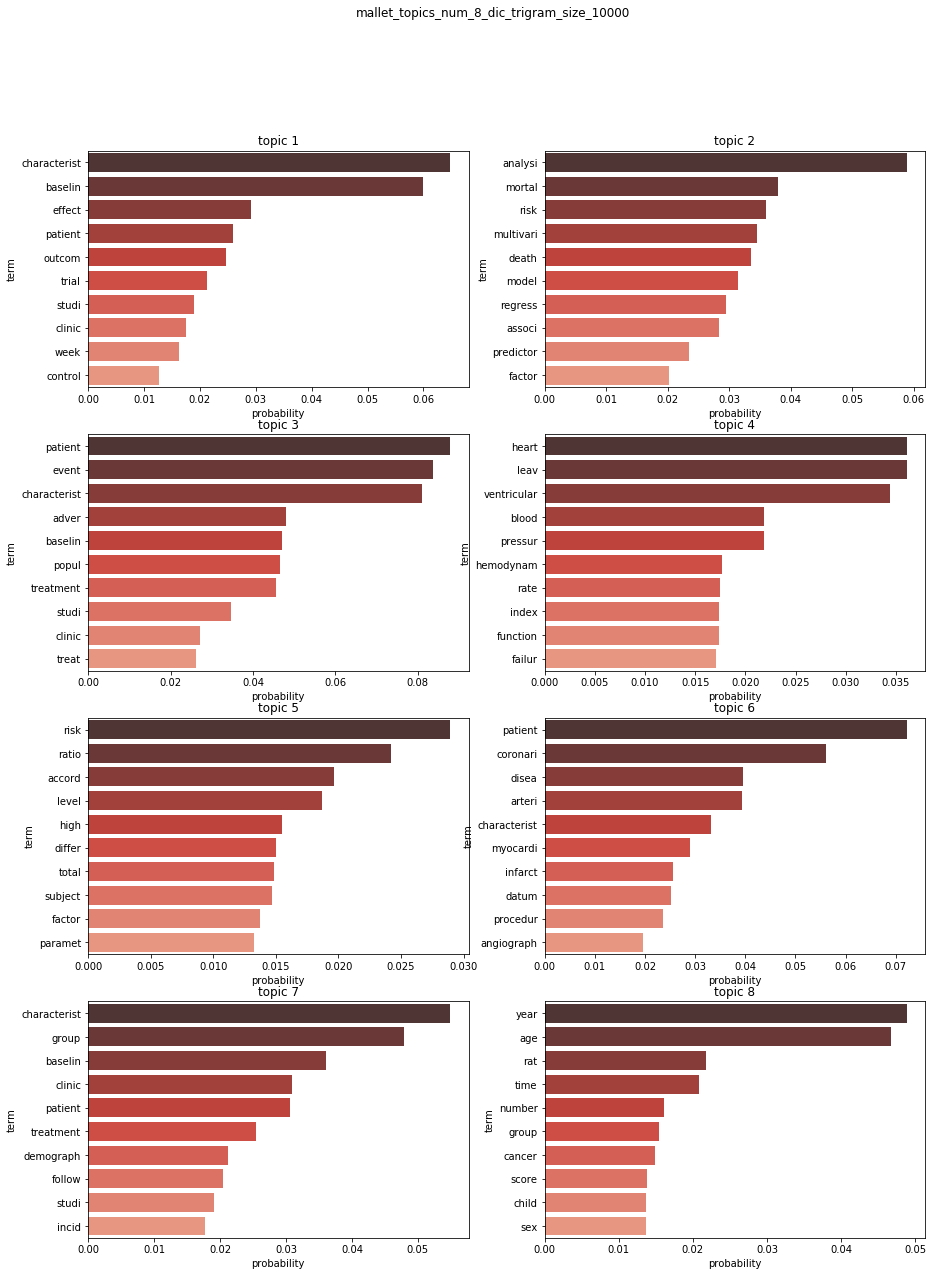

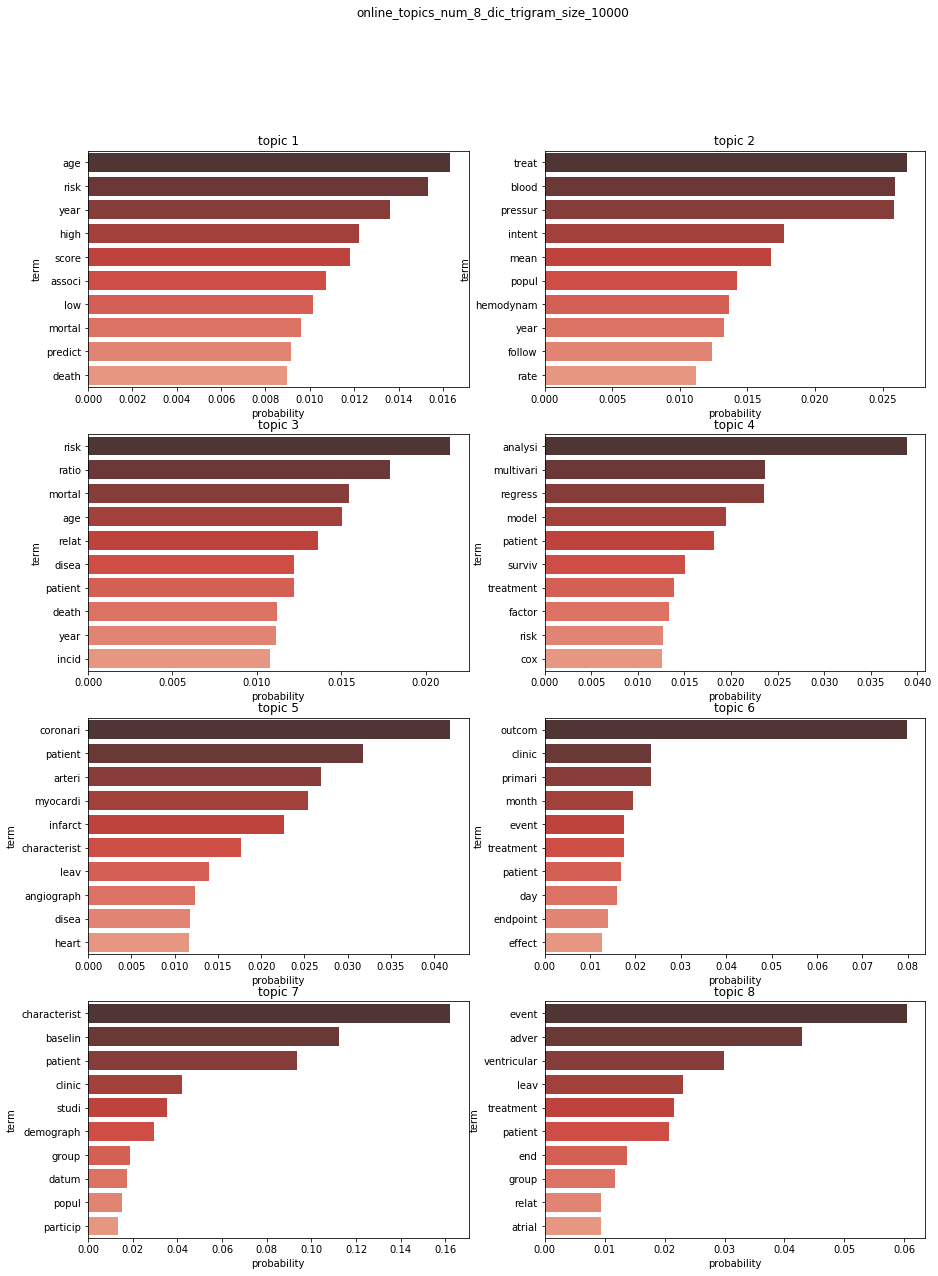

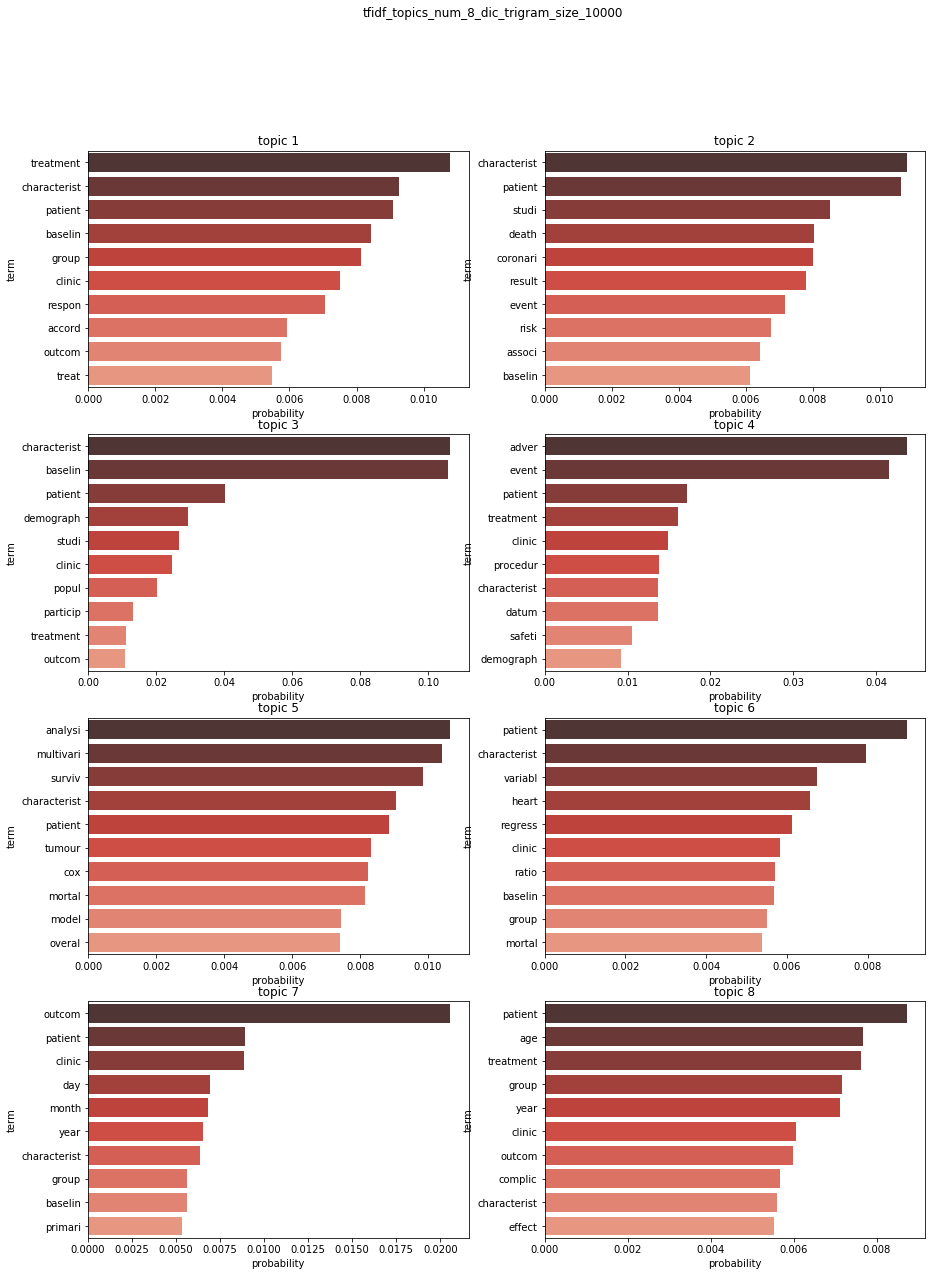

In [22]:
mallet_model = get_optimal_model('mallet', max_coherence_topic_num)
on_model = get_optimal_model('online', max_coherence_topic_num_on)
tfidf_model = get_optimal_model('tfidf', max_coherence_topic_num_tfidf)

In [23]:
# #Check topic distribution of a sample data
# for ind, score in sorted(lda_mallet[bow_corpus[45]], key=lambda x: -1*x[1]):
#     print('\nScore: {}\t \nTopic: {}'.format(score, lda_mallet.print_topic(ind, 10)))

In [24]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [25]:
import gzip
import os

dataDir = directory+'/data/'

def extract_params(statefile):
    """extract alpha and beta values from MALLET statefile by path to statfile
    
    Args:
        statefile (str) : Path to statefile produced by MALLET
    Returns:
        tuple: alpha (list), beta
    """
    
#     with codecs.open(statefile, "r",encoding='utf-8') as state:
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf-8').strip() for x in state.readlines()[1:3]]
#         params = [x.strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(':')[1].split(" ")), float(params[1].split(':')[1]))

def state_to_df(statefile):
    """transform state file into pandas dataframe
    the MALLET statefile is tab-separated, and the first two rows contain the alpha and beta parameters
    
    Args:
        statefile (str): Path to statefile produced by MALLET
    Returns:
        dataframe: topic assignment for each token in each documnet of the model
    """
    return pd.read_csv(statefile,\
                      compression='gzip',\
                      sep=' ',\
                      skiprows=[1,2])

In [26]:
params = extract_params(os.path.join(dataDir, 'state.mallet.gz'))
alpha = [float(x) for x in params[0][1:]]
beta = params[1]
print("{}, {}".format(alpha, beta))

df = state_to_df(os.path.join(dataDir, 'state.mallet.gz'))
df['type'] = df.type.astype(str)
df[:5]
#doc id, word position index, word index, topic assignmnet

[6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25], 0.01


,#doc,source,pos,typeindex,type,topic
0,0,NaN,0,0,baselin,0
1,0,NaN,1,1,characterist,6
2,1,NaN,0,2,analysi,1
3,1,NaN,1,3,efficaci,6
4,2,NaN,0,4,antigen,0


In [27]:
#to get the length of the document, group by the document id and count the tokens
docs = df.groupby('#doc')['type'].count().reset_index(name='doc_length')
docs[:10]

#get vocab and term frequencies
vocab = df['type'].value_counts().reset_index()
vocab.columns = ['type', 'term_freq']
vocab = vocab.sort_values(by='type', ascending=True)
vocab[:5]

,type,term_freq
9854,aa,1
2278,aaa,12
4912,aac,3
2076,aad,14
5562,aai,3


In [28]:
#matrix file
#need to normalize data so that each row sums to 1
import sklearn.preprocessing

def pivot_and_smooth(df, smooth_values, rows_variable, cols_variable, values_variable):
    """
    modify dataframe into matrix
    Args:
        df (dataframe) : 
        smooth_values (float) : value to add to the matrix to account for the priors
        rows_variable (str) : title of rows
        cols_variable (str) : title of columns
        values_variable (str) : values
    Returns:
        dataframe : that has been normalized on the rows.
    """
    matrix = df.pivot(index=rows_variable, columns=cols_variable, values=values_variable).fillna(value=0)
    matrix = matrix.values + smooth_values
    
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    
    return pd.DataFrame(normed)

In [29]:
#get the number of topic assingments for words in documents
#phi - topic-term matrix and counted the number of times each word was assigned to each topic 
#and sorted by alphabetically to match the order of the vocabulary frame

#beta as the smoothign value
phi_df = df.groupby(['topic', 'type'])['type'].count().reset_index(name='token_count')
phi_df = phi_df.sort_values(by='type', ascending=True)
phi_df[:5]

phi = pivot_and_smooth(phi_df, beta, 'topic', 'type', 'token_count')
phi[:5]

#theta document-topic matrix and use alpha as the smoothign value
theta_df = df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name='topic_count')
theta_df[:5]

theta = pivot_and_smooth(theta_df, alpha, '#doc', 'topic', 'topic_count')
theta[:5]

,0,1,2,3,4,5,6,7
0,0.139423,0.120192,0.120192,0.120192,0.120192,0.120192,0.139423,0.120192
1,0.120192,0.139423,0.120192,0.120192,0.120192,0.120192,0.139423,0.120192
2,0.173729,0.122881,0.122881,0.105932,0.139831,0.122881,0.105932,0.105932
3,0.117925,0.117925,0.117925,0.136792,0.155660,0.117925,0.117925,0.117925
4,0.111607,0.129464,0.200893,0.111607,0.111607,0.111607,0.111607,0.111607


In [30]:
lda_mallet_data = {
    'topic_term_dists':phi,
    'doc_topic_dists':theta,
    'doc_lengths':list(docs['doc_length']),
    'vocab':list(vocab['type']),
    'term_frequency':list(vocab['term_freq'])
}
mallet_vis_data = pyLDAvis.prepare(**lda_mallet_data)
pyLDAvis.display(mallet_vis_data)
pyLDAvis.save_html(mallet_vis_data, directory+'/mallet_topics_num_'+str(max_coherence_topic_num)+'.html')

In [31]:
#each bubble = topic, the larger the bubble, the more prevalent is that topic
#good topic = fairly big, non-overlapping bubbles scattered throughout the chart
#model with too many topics = typically have many overlaps, small sized bubbles in one region of the chart
data_tfidf = pyLDAvis.gensim.prepare(tfidf_model, tfidf_corpus, dictionary)
data_tfidf

#bar = salient keywords that form the selected topic
pyLDAvis.display(data_tfidf)
pyLDAvis.save_html(data_tfidf, directory+'/tfidf_topics_num_'+str(max_coherence_topic_num_tfidf)+'.html')

data_on = pyLDAvis.gensim.prepare(on_model, bow_corpus, dictionary)
data_on

pyLDAvis.display(data_on)
pyLDAvis.save_html(data_on, directory+'/online_topics_num_'+str(max_coherence_topic_num_on)+'.html')

#### Perplexity and Coherence score
- model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is

In [32]:
#compute perplexity : a measure of how good the model is
# lower the better
# print('\nPerplexit: ', lda_mallet.log_perplexity(bow_corpus))
# print('\nPerplexit: ', lda_model_tfidf.log_perplexity(bow_corpus))

In [33]:
from gensim.models import CoherenceModel

#compute coherence score
coherence_model_lda = CoherenceModel(model=mallet_model, texts=processed_trigram, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#compute coherence score
coherence_model_lda_tfidf = CoherenceModel(model=tfidf_model, texts=processed_trigram, dictionary=dictionary, coherence='c_v')
coherence_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
print('\nTF-IDF Coherence Score: ', coherence_lda_tfidf)

#compute coherence score
coherence_model_lda_on = CoherenceModel(model=on_model, texts=processed_trigram, dictionary=dictionary, coherence='c_v')
coherence_lda_on = coherence_model_lda_on.get_coherence()
print('\nONLINE Coherence Score: ', coherence_lda_on)


Coherence Score:  0.46991536099825104

TF-IDF Coherence Score:  0.2611051759121236

ONLINE Coherence Score:  0.4267454172580602


### Find dominant topic
- find the most contributed topic

In [34]:
processed_docs = processed_docs.merge(documents, on='id')
# test = processed_docs[['id', 'title_x', 'bow_corpus', 'title_y']]
# test.to_csv('test.csv')

In [35]:
processed_docs.head(5)

,id,title_x,bigram,trigram,bow_corpus,tfidf_corpus,title_y
0,4105,"[baselin, characterist]","[baselin, characterist]","[baselin, characterist]","[(0, 1), (1, 1)]","[(0, 0.7886588133512408), (1, 0.61483109560546...",Baseline characteristics
1,4106,"[analysi, efficaci]","[analysi, efficaci]","[analysi, efficaci]","[(2, 1), (3, 1)]","[(2, 0.5383488864860368), (3, 0.84272206356499...",Analysis of efficacy
2,4107,"[comparison, postop, carbohydr, antigen, level...","[comparison, postop, carbohydr, antigen, level...","[comparison, postop, carbohydr, antigen, level...","[(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1...","[(4, 0.32042002537018816), (5, 0.4214040142210...",Comparisons of postoperative carbohydrate anti...
3,4108,"[pattern, diseas, relaps]","[pattern, disea, relap]","[pattern, disea, relap]","[(13, 1), (14, 1), (15, 1)]","[(13, 0.35844656165152977), (14, 0.64617554928...",Pattern of disease relapse
4,4109,"[grade, advers, event, gemcitabin, gemcitabin,...","[grade, adver, event, gemcitabin, gemcitabin, ...","[grade, adver, event, gemcitabin, gemcitabin, ...","[(16, 1), (17, 1), (18, 1), (19, 2), (20, 1)]","[(16, 0.13700238921997265), (17, 0.39160402456...",Grade 1–5 adverse events with gemcitabine alon...


In [36]:
processed_docs.iloc[151]

id                                                           4261
title_x         [paramet, initi, pattern, af, valu, present, m...
bigram          [paramet, initi, pattern, valu, present, mean,...
trigram         [paramet, initi, pattern, valu, present, mean,...
bow_corpus      [(14, 1), (84, 1), (96, 1), (228, 1), (241, 1)...
tfidf_corpus    [(14, 0.23960090961976876), (84, 0.10604000839...
title_y         Electrophysiologic Parameters of Two Initiatio...
Name: 151, dtype: object

In [37]:
import random

def format_topics_sentences(model, \
                            model_type='mallet', \
                            corpus=processed_docs, \
                            texts=dictionary_made_by):
    sent_topic_df = pd.DataFrame()
    if model_type=='tfidf':
        target_corpus = corpus.tfidf_corpus
    else:
        target_corpus = corpus.bow_corpus
    
    for i, row in enumerate(model[target_corpus]):
        origin_info = processed_docs.iloc[i]
        text_vec = texts[i]
        #get main topic in each document
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0: #dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
#                 print(pd.Series([origin_info.id,\
#                                 int(topic_num), \
#                                 round(prop_topic, 4), \
#                                 topic_keywords, \
#                                origin_info.title_y, \
#                                text_vec]))
                sent_topic_df = sent_topic_df.append(pd.Series([origin_info.id,\
                                                                int(topic_num), \
                                                                round(prop_topic, 4), \
                                                                topic_keywords, \
                                                               origin_info.title_y, \
                                                               text_vec]), ignore_index=True)
            else:
                break
    sent_topic_df.columns = ['id', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Origin_Text', 'Text_Vec']
    
    return (sent_topic_df)

In [38]:
df_topic_sents_keywords_mallet = format_topics_sentences(model=mallet_model, \
                                                  corpus=processed_docs, \
                                                  texts=dictionary_made_by, \
                                                 model_type='mallet')
df_topic_sents_keywords_mallet.head(5)

,id,Dominant_Topic,Perc_Contribution,Topic_Keywords,Origin_Text,Text_Vec
0,4105,0.0,0.1351,"characterist, baselin, effect, patient, outcom...",Baseline characteristics,"[baselin, characterist]"
1,4106,1.0,0.1373,"analysi, mortal, risk, multivari, death, model...",Analysis of efficacy,"[analysi, efficaci]"
2,4107,0.0,0.1756,"characterist, baselin, effect, patient, outcom...",Comparisons of postoperative carbohydrate anti...,"[comparison, postop, carbohydr, antigen, level..."
3,4108,4.0,0.1368,"risk, ratio, accord, level, high, differ, tota...",Pattern of disease relapse,"[pattern, disea, relap]"
4,4109,2.0,0.1949,"patient, event, characterist, adver, baselin, ...",Grade 1–5 adverse events with gemcitabine alon...,"[grade, adver, event, gemcitabin, gemcitabin, ..."


In [39]:
df_topic_sents_keywords_tfidf = format_topics_sentences(model=tfidf_model, \
                                                  corpus=processed_docs, \
                                                  texts=dictionary_made_by, \
                                                 model_type='tfidf')
df_topic_sents_keywords_tfidf.head(5)

,id,Dominant_Topic,Perc_Contribution,Topic_Keywords,Origin_Text,Text_Vec
0,4105,2.0,0.6359,"characterist, baselin, patient, demograph, stu...",Baseline characteristics,"[baselin, characterist]"
1,4106,2.0,0.6318,"characterist, baselin, patient, demograph, stu...",Analysis of efficacy,"[analysi, efficaci]"
2,4107,2.0,0.4300,"characterist, baselin, patient, demograph, stu...",Comparisons of postoperative carbohydrate anti...,"[comparison, postop, carbohydr, antigen, level..."
3,4108,4.0,0.6729,"analysi, multivari, surviv, characterist, pati...",Pattern of disease relapse,"[pattern, disea, relap]"
4,4109,3.0,0.6789,"adver, event, patient, treatment, clinic, proc...",Grade 1–5 adverse events with gemcitabine alon...,"[grade, adver, event, gemcitabin, gemcitabin, ..."


In [40]:
df_topic_sents_keywords_on = format_topics_sentences(model=on_model, \
                                                  corpus=processed_docs, \
                                                  texts=dictionary_made_by, \
                                                 model_type='online')
df_topic_sents_keywords_on.head(5)

,id,Dominant_Topic,Perc_Contribution,Topic_Keywords,Origin_Text,Text_Vec
0,4105,6.0,0.7083,"characterist, baselin, patient, clinic, studi,...",Baseline characteristics,"[baselin, characterist]"
1,4106,5.0,0.4019,"outcom, clinic, primari, month, event, treatme...",Analysis of efficacy,"[analysi, efficaci]"
2,4107,2.0,0.4593,"risk, ratio, mortal, age, relat, disea, patien...",Comparisons of postoperative carbohydrate anti...,"[comparison, postop, carbohydr, antigen, level..."
3,4108,3.0,0.7810,"analysi, multivari, regress, model, patient, s...",Pattern of disease relapse,"[pattern, disea, relap]"
4,4109,7.0,0.5136,"event, adver, ventricular, leav, treatment, pa...",Grade 1–5 adverse events with gemcitabine alon...,"[grade, adver, event, gemcitabin, gemcitabin, ..."


In [41]:
print(df_topic_sents_keywords_mallet.isna().any())
print('=================')
print(df_topic_sents_keywords_tfidf.isna().any())
print('=================')
print(df_topic_sents_keywords_on.isna().any())

id                   False
Dominant_Topic       False
Perc_Contribution    False
Topic_Keywords       False
Origin_Text          False
Text_Vec             False
dtype: bool
id                   False
Dominant_Topic       False
Perc_Contribution    False
Topic_Keywords       False
Origin_Text          False
Text_Vec             False
dtype: bool
id                   False
Dominant_Topic       False
Perc_Contribution    False
Topic_Keywords       False
Origin_Text          False
Text_Vec             False
dtype: bool


#### 각 토픽별로 가장 대표적인 문서 찾기

In [42]:
def get_rep_sents(keywords, model_type):
    sent_topics_sorted_df_mallet = pd.DataFrame()
    
    sent_topics_groupby = keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_groupby:
        keywords = pd.concat([keywords, \
                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], \
                            axis=0)

    keywords.reset_index(drop=True, inplace=True)
    keywords.columns = ['id', 'Topic_Num', 'Topic_Perc_Contribu', 'Topic_Keywords', 'Origin_Text', 'Text']
    keywords.to_csv(directory+'/'+model_type+'_top_sen.tsv', sep='\t')
    return keywords
    
df_topic_sents_mallet = get_rep_sents(df_topic_sents_keywords_mallet, 'mallet')
df_topic_sents_tfidf = get_rep_sents(df_topic_sents_keywords_tfidf, 'tfidf')
df_topic_sents_on = get_rep_sents(df_topic_sents_keywords_on, 'online')

In [51]:
df_topic_sents_keywords_mallet.head(5)

,id,Dominant_Topic,Perc_Contribution,Topic_Keywords,Origin_Text,Text_Vec
0,4105,0.0,0.1351,"characterist, baselin, effect, patient, outcom, trial, studi, clinic, week, control",Baseline characteristics,"[baselin, characterist]"
1,4106,1.0,0.1373,"analysi, mortal, risk, multivari, death, model, regress, associ, predictor, factor",Analysis of efficacy,"[analysi, efficaci]"
2,4107,0.0,0.1756,"characterist, baselin, effect, patient, outcom, trial, studi, clinic, week, control",Comparisons of postoperative carbohydrate antigen 19-9 levels on survival of ESPAC-4 with the CONOKO-01 and JASPAC-1 trials,"[comparison, postop, carbohydr, antigen, level, surviv, espac, conoko, jaspac, trial]"
3,4108,4.0,0.1368,"risk, ratio, accord, level, high, differ, total, subject, factor, paramet",Pattern of disease relapse,"[pattern, disea, relap]"
4,4109,2.0,0.1949,"patient, event, characterist, adver, baselin, popul, treatment, studi, clinic, treat",Grade 1–5 adverse events with gemcitabine alone and gemcitabine plus capecitabine,"[grade, adver, event, gemcitabin, gemcitabin, capecitabin]"


#### 문서 전체적인 토픽 분포

In [52]:
pd.set_option('display.max_colwidth', -1)

topic_counts = df_topic_sents_mallet['Topic_Num'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_sents_mallet[['Topic_Num', 'Topic_Keywords']]

df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
df_dominant_topics.reset_index(level=0, inplace=True)
df_dominant_topics.columns = ['Topic_Num', 'Num_Documents', 'Perc_Documents']
df_dominant_topics = df_dominant_topics.merge(topic_num_keywords.drop_duplicates(), on='Topic_Num')
df_dominant_topics = df_dominant_topics.sort_values('Topic_Num')

df_dominant_topics.reset_index(drop = True, inplace = True)
df_dominant_topics.to_html(directory+'/mallet_distribution.html', index=False)
df_dominant_topics.head(max_coherence_topic_num)

,Topic_Num,Num_Documents,Perc_Documents,Topic_Keywords
0,0.0,6269,0.1380,"characterist, baselin, effect, patient, outcom, trial, studi, clinic, week, control"
1,1.0,6249,0.1375,"analysi, mortal, risk, multivari, death, model, regress, associ, predictor, factor"
2,2.0,7931,0.1746,"patient, event, characterist, adver, baselin, popul, treatment, studi, clinic, treat"
3,3.0,5378,0.1184,"heart, leav, ventricular, blood, pressur, hemodynam, rate, index, function, failur"
4,4.0,4721,0.1039,"risk, ratio, accord, level, high, differ, total, subject, factor, paramet"
5,5.0,5036,0.1108,"patient, coronari, disea, arteri, characterist, myocardi, infarct, datum, procedur, angiograph"
6,6.0,5154,0.1134,"characterist, group, baselin, clinic, patient, treatment, demograph, follow, studi, incid"
7,7.0,4694,0.1033,"year, age, rat, time, number, group, cancer, score, child, sex"


In [55]:
topic_counts = df_topic_sents_keywords_tfidf['Dominant_Topic'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_sents_keywords_tfidf[['Dominant_Topic', 'Topic_Keywords']]

df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
df_dominant_topics.reset_index(level=0, inplace=True)
df_dominant_topics.columns = ['Dominant_Topic', 'Num_Documents', 'Perc_Documents']
df_dominant_topics = df_dominant_topics.merge(topic_num_keywords.drop_duplicates(), on='Dominant_Topic')
df_dominant_topics = df_dominant_topics.sort_values('Dominant_Topic')

df_dominant_topics.reset_index(drop = True, inplace = True)
df_dominant_topics.to_html(directory+'/tfidf_distribution.html', index=False)
df_dominant_topics.head(max_coherence_topic_num_tfidf)

,Dominant_Topic,Num_Documents,Perc_Documents,Topic_Keywords
0,0.0,4700,0.1036,"treatment, characterist, patient, baselin, group, clinic, respon, accord, outcom, treat"
1,1.0,4794,0.1057,"characterist, patient, studi, death, coronari, result, event, risk, associ, baselin"
2,2.0,8238,0.1816,"characterist, baselin, patient, demograph, studi, clinic, popul, particip, treatment, outcom"
3,3.0,5849,0.1290,"adver, event, patient, treatment, clinic, procedur, characterist, datum, safeti, demograph"
4,4.0,5246,0.1157,"analysi, multivari, surviv, characterist, patient, tumour, cox, mortal, model, overal"
5,5.0,5592,0.1233,"patient, characterist, variabl, heart, regress, clinic, ratio, baselin, group, mortal"
6,6.0,5784,0.1275,"outcom, patient, clinic, day, month, year, characterist, group, baselin, primari"
7,7.0,5149,0.1135,"patient, age, treatment, group, year, clinic, outcom, complic, characterist, effect"


In [56]:
topic_counts = df_topic_sents_keywords_on['Dominant_Topic'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_sents_keywords_on[['Dominant_Topic', 'Topic_Keywords']]

df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
df_dominant_topics.reset_index(level=0, inplace=True)
df_dominant_topics.columns = ['Dominant_Topic', 'Num_Documents', 'Perc_Documents']
df_dominant_topics = df_dominant_topics.merge(topic_num_keywords.drop_duplicates(), on='Dominant_Topic')
df_dominant_topics = df_dominant_topics.sort_values('Dominant_Topic')

df_dominant_topics.reset_index(drop = True, inplace = True)
df_dominant_topics.to_html(directory+'/on_distribution.html', index=False)
df_dominant_topics.head(max_coherence_topic_num_on)

,Dominant_Topic,Num_Documents,Perc_Documents,Topic_Keywords
0,0.0,4332,0.0955,"age, risk, year, high, score, associ, low, mortal, predict, death"
1,1.0,3769,0.0831,"treat, blood, pressur, intent, mean, popul, hemodynam, year, follow, rate"
2,2.0,6382,0.1407,"risk, ratio, mortal, age, relat, disea, patient, death, year, incid"
3,3.0,5908,0.1303,"analysi, multivari, regress, model, patient, surviv, treatment, factor, risk, cox"
4,4.0,4298,0.0948,"coronari, patient, arteri, myocardi, infarct, characterist, leav, angiograph, disea, heart"
5,5.0,5274,0.1163,"outcom, clinic, primari, month, event, treatment, patient, day, endpoint, effect"
6,6.0,10882,0.2399,"characterist, baselin, patient, clinic, studi, demograph, group, datum, popul, particip"
7,7.0,4507,0.0994,"event, adver, ventricular, leav, treatment, patient, end, group, relat, atrial"


- https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

- https://ai.googleblog.com/2016/12/open-sourcing-embedding-projector-tool.html
- http://projector.tensorflow.org/
- http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb#loading

In [ ]:
### Evaluate testing dataset by cosine similarity 
- between corresponding parts (higher the better)
- between 10,000 random parts (lower the better)